This notebook provides a comprehensive guide on how to utilize Facebook's FastText library for text classification tasks. FastText is a powerful open-source library developed by Facebook's AI research team that provides state-of-the-art performance in natural language processing (NLP) tasks such as text classification, sentiment analysis, and language modeling.

We demonstrate how to implement FastText for text classification tasks by providing a step-by-step guide on how to train a text classifier on a large corpus of text data. We will explore the different hyperparameters and feature engineering techniques that can be used to optimize the performance of the FastText classifier.

By following the steps outlined in this notebook, you will be able to leverage the power of FastText for text classification tasks and achieve state-of-the-art performance. In particular, you will gain the potential of integrating FastText with LightGBM classier using TUNIZI data set.

LightGBM is a gradient boosting framework that is commonly used for machine learning tasks such as classification, regression, and ranking. It is designed to be highly efficient, scalable, and accurate, making it a popular choice for handling large-scale data sets.

One of the key advantages of LightGBM is its ability to handle sparse data, making it well-suited for text classification tasks where the input data is typically high-dimensional and sparse. It uses a histogram-based algorithm to bin feature values, allowing for faster computation of the gradient and reducing the memory requirements of the algorithm.

LightGBM also offers various hyperparameters that can be tuned to optimize the performance of the classification algorithm. These include parameters that control the depth and number of trees, the learning rate, and the regularization parameters.

In this notebook, we will be using LightGBM as a classification algorithm to predict the category of each text sample in the TUNIZI data set. We will demonstrate how to integrate FastText with LightGBM to preprocess the text data and generate word embeddings, which can then be used as input to the classification algorithm.

We will also provide a step-by-step guide on how to tune the hyperparameters of the LightGBM algorithm to achieve optimal performance on the TUNIZI data set. This will involve using techniques such as grid search or randomized search to explore the hyperparameter space and identify the best combination of hyperparameters.

By using LightGBM as the classification algorithm in combination with FastText, we will be able to achieve state-of-the-art performance on the TUNIZI data set and develop robust and accurate text classification models for various real-world applications.

In [1]:
import io
import os
import gc
import re
import pickle
import random
import termcolor
import warnings
import shutil
from collections import Counter
from functools import partial
from datetime import datetime
from dataclasses import dataclass
from pathlib import Path
from typing import List

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import  accuracy_score

import lightgbm as lgbm
from joblib import dump, load

In [2]:
#!pip install -q git+https://github.com/facebookresearch/fastText.git
#!pip install -q texthero

In [3]:
import fasttext
import texthero
from nltk.corpus import stopwords

In [4]:
stopwords_list = stopwords.words('english') + stopwords.words('french')

# Config

In [5]:
DEBUG = True
SAVE_PATH = None
SEED = 42
NOW = datetime.strftime(datetime.now() , "%m%d")

SAVE_PATH = Path(f'../input/')
SAVE_PATH.mkdir(exist_ok=True)

NUM_WORKERS = os.cpu_count()

print("DEBUG:\t", DEBUG)
print("SAVE_PATH:\t", SAVE_PATH)
print("NUM_WORKERS:\t", NUM_WORKERS)

DEBUG:	 True
SAVE_PATH:	 ../input
NUM_WORKERS:	 12


In [6]:
# @dataclass
# class Config:
#     max_seq_len:int = 192
#     num_fold:int = 5

#     lr:float = 3e-5
#     batch_size: int = 128
#     num_epoch:int = 10
#     max_grad_norm:float = 1.0
#     gradient_accumulation_steps: int = 1
#     warmup_steps: int = 0
#     weight_decay: float = 0.0
#     adam_beta1: float = 0.9
#     adam_beta2: float = 0.999
#     adam_epsilon: float= 1e-8
#     max_grad_norm: float = 1.0

#     save_top_k:int = 1

#     def __post_init__(self):
#         pass


# cfg = Config()
# cfg

# Helper

In [7]:
def save_pkl(dir, name, obj):
    dir.mkdir(exist_ok=True)
    with open(dir / name, 'wb') as f:
        pickle.dump(obj, f)

def load_pkl(dir, name):
    with open(dir / name, 'rb') as f:
        return pickle.load(f)

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

In [8]:
set_seed(SEED)

# Load Data

In [9]:
train_df = pd.read_csv("./input/Train.csv")
test_df = pd.read_csv("./input/Test.csv")

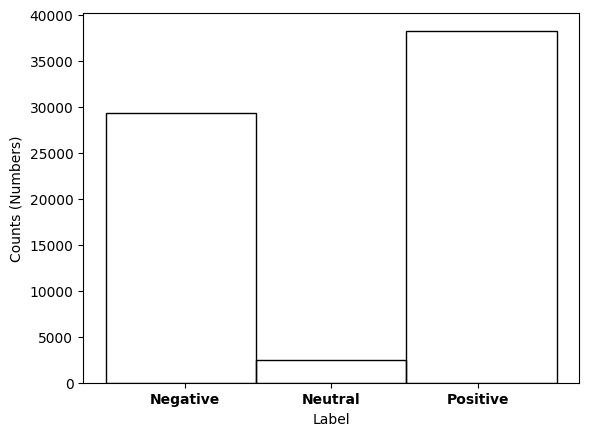

In [23]:
import matplotlib.pyplot as plt

# Create histogram
plt.hist(train_df['label'], bins=3, edgecolor='black', fill=False)

# Add axis labels
plt.xlabel('Label')
plt.ylabel('Counts (Numbers)')

plt.xticks([-0.65, 0, 0.65], ['Negative', 'Neutral', 'Positive'],fontweight='bold')

plt.savefig('f1.png')

# Show plot
plt.show()


In [32]:
LABEL2ID = {label:i for i, label in enumerate(train_df['label'].unique())}
ID2LABEL = {v:k for k, v in LABEL2ID.items()}

train_df['label_ids'] = train_df['label'].map(LABEL2ID)

In [33]:
train_df

,ID,text,label,label_ids
0,ID_13P0QT0,3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...,-1,0
1,ID_SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1,0
2,ID_V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1,0
3,ID_U0TTYY8,ak slouma,1,1
4,ID_68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1,0
...,...,...,...,...
69995,ID_ZRSR7TZ,pff bayna beli kbira f wejhakk yakhiii rouhi r...,-1,0
69996,ID_QNQVEIH,aman lmara jeya zidou t3am9ou fel a7deeth akth...,-1,0
69997,ID_LJ2K9MD,winha nakhtabha hhhhh,-1,0
69998,ID_5RZ1T7I,fachel enta w houwa,-1,0


In [34]:
train_targets = train_df['label_ids'].values

In [35]:
all_texts = pd.concat([train_df['text'].str.lower(), test_df['text'].str.lower()])

In [36]:
all_texts = texthero.remove_stopwords(all_texts, stopwords_list)
all_texts = texthero.remove_whitespace(all_texts)

In [37]:
all_texts

0        3sbaaaaaaaaaaaaaaaaaaaa lek seim riahi 3sbaaaa...
1                cha3eb fey9elkoum menghir ta7ayoul kressi
2        bereau degage nathef ya slim walahi ya7chiw fi...
3                                                ak slouma
4        entom titmanou lina a7na 3iid moubarik a7na ch...
                               ...                        
29995                                         ihebekch raw
29996    nchallah rabi m3ak w iwaf9ek 7abit nes2l win w...
29997    slim rabi m3ak w e5edem w 5alli l7ossed lemnay...
29998    bara 5alis rouhik yizi mitbal3it jam3iya hlaki...
29999    rabi m3aaaak ya khawlaaa n7ebouuuuk rana barsh...
Name: text, Length: 100000, dtype: object

# Train Fasttext

In [21]:
with open("../input/data.txt", "w") as f:
    for line in all_texts:
        f.write(line+"\n")

In [22]:
%%time
fattext_model = fasttext.train_unsupervised("../input/data.txt", model='skipgram', dim=300, wordNgrams=2, epoch=10)

Read 1M words
Number of words:  18460
Number of labels: 0
Progress:  99.4% words/sec/thread:   24425 lr:  0.000324 avg.loss:  2.090959 ETA:   0h 0m 0s

CPU times: user 7min 9s, sys: 1.2 s, total: 7min 10s
Wall time: 40.6 s


Progress: 100.0% words/sec/thread:   24394 lr:  0.000000 avg.loss:  2.089059 ETA:   0h 0m 0s


In [23]:
all_features = [fattext_model.get_sentence_vector(text) for text in tqdm(all_texts)]
all_features = np.vstack(all_features)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [25]:
all_features = np.vstack(all_features)

In [28]:
train_features = all_features[:len(train_df)]
test_features = all_features[len(train_df):]

# Model

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
import numpy as np

param_distributions = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [16, 32, 64],
    'max_depth': [6, 8, 12],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0.01, 0.1, 1.0],
    'reg_lambda': [0.01, 0.1, 1.0],
}

model = LGBMClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='f1_micro',
    verbose=3,
    random_state=42,
)

random_search.fit(train_features, train_targets)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=100, num_leaves=16, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6;, score=0.786 total time=   8.5s
[CV 2/5] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=100, num_leaves=16, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6;, score=0.784 total time=   9.4s
[CV 3/5] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=100, num_leaves=16, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6;, score=0.787 total time=  18.3s
[CV 4/5] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=100, num_leaves=16, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6;, score=0.793 total time=   9.8s
[CV 5/5] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=100, num_leaves=16, reg_alph

[CV 2/5] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, min_child_weight=10, n_estimators=500, num_leaves=16, reg_alpha=0.01, reg_lambda=0.1, subsample=1.0;, score=0.785 total time=  38.3s
[CV 3/5] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, min_child_weight=10, n_estimators=500, num_leaves=16, reg_alpha=0.01, reg_lambda=0.1, subsample=1.0;, score=0.786 total time=  37.8s
[CV 4/5] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, min_child_weight=10, n_estimators=500, num_leaves=16, reg_alpha=0.01, reg_lambda=0.1, subsample=1.0;, score=0.793 total time=  38.0s
[CV 5/5] END colsample_bytree=1.0, learning_rate=0.01, max_depth=8, min_child_weight=10, n_estimators=500, num_leaves=16, reg_alpha=0.01, reg_lambda=0.1, subsample=1.0;, score=0.791 total time=  38.7s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, num_leaves=16, reg_alpha=1.0, reg_lambda=0.1, subsample=1.0;, score=0.800 total time=  44.

[CV 3/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=1000, num_leaves=32, reg_alpha=0.01, reg_lambda=0.01, subsample=1.0;, score=0.800 total time=  45.2s
[CV 4/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=1000, num_leaves=32, reg_alpha=0.01, reg_lambda=0.01, subsample=1.0;, score=0.808 total time=  47.6s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=1000, num_leaves=32, reg_alpha=0.01, reg_lambda=0.01, subsample=1.0;, score=0.810 total time=  46.0s
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=12, min_child_weight=10, n_estimators=500, num_leaves=16, reg_alpha=1.0, reg_lambda=0.1, subsample=0.6;, score=0.799 total time=  18.8s
[CV 2/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=12, min_child_weight=10, n_estimators=500, num_leaves=16, reg_alpha=1.0, reg_lambda=0.1, subsample=0.6;, score=0.800 total time=  

[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, num_leaves=32, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6;, score=0.803 total time=  54.5s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=1000, num_leaves=32, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6;, score=0.805 total time=  54.9s
[CV 1/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, min_child_weight=1, n_estimators=1000, num_leaves=16, reg_alpha=0.01, reg_lambda=0.01, subsample=1.0;, score=0.805 total time=  55.8s
[CV 2/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, min_child_weight=1, n_estimators=1000, num_leaves=16, reg_alpha=0.01, reg_lambda=0.01, subsample=1.0;, score=0.801 total time=  55.4s
[CV 3/5] END colsample_bytree=1.0, learning_rate=0.1, max_depth=12, min_child_weight=1, n_estimators=1000, num_leaves=16, reg_alpha=0.01, reg_lambda=0.01, subsample=1.0;, score=0.801 total tim

[CV 5/5] END colsample_bytree=0.6, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=100, num_leaves=16, reg_alpha=0.01, reg_lambda=0.01, subsample=1.0;, score=0.793 total time=   5.3s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=500, num_leaves=16, reg_alpha=0.1, reg_lambda=0.01, subsample=0.6;, score=0.800 total time=  23.7s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=500, num_leaves=16, reg_alpha=0.1, reg_lambda=0.01, subsample=0.6;, score=0.797 total time=  23.8s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=500, num_leaves=16, reg_alpha=0.1, reg_lambda=0.01, subsample=0.6;, score=0.796 total time=  23.8s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=500, num_leaves=16, reg_alpha=0.1, reg_lambda=0.01, subsample=0.6;, score=0.802 total time=  23.6

[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500, num_leaves=16, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6;, score=0.801 total time=  21.9s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500, num_leaves=16, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6;, score=0.801 total time=  21.8s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500, num_leaves=16, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6;, score=0.797 total time=  22.0s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500, num_leaves=16, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6;, score=0.803 total time=  21.7s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=500, num_leaves=16, reg_alpha=0.01, reg_lambda=0.01, subsample=0.6;, score=0.807 total time=  22.0s


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=12, min_child_weight=1, n_estimators=500, num_leaves=32, reg_alpha=1.0, reg_lambda=0.01, subsample=0.8;, score=0.789 total time=  36.4s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=12, min_child_weight=1, n_estimators=500, num_leaves=32, reg_alpha=1.0, reg_lambda=0.01, subsample=0.8;, score=0.791 total time=  36.7s
[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=12, min_child_weight=1, n_estimators=500, num_leaves=32, reg_alpha=1.0, reg_lambda=0.01, subsample=0.8;, score=0.799 total time=  36.3s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=12, min_child_weight=1, n_estimators=500, num_leaves=32, reg_alpha=1.0, reg_lambda=0.01, subsample=0.8;, score=0.797 total time=  36.5s
Best parameters: {'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'num_leaves': 64, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1